In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashimaarora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#pip install wordcloud

In [ ]:
#pip install xgboost

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle #save model
import re

In [4]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "amazon_alexa.tsv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sid321axn/amazon-alexa-reviews",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/var/folders/xy/_8sy78y94s98hlr1n_08t5bm0000gn/T/ipykernel_18449/3697396930.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:    rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  


# Data Exploration

In [5]:
df.shape

(3150, 5)

In [3]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [8]:
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
review_length        int64
dtype: object

This data has 5 columns and 3150 rows. There are no NULL values in the data.

In [5]:
df['review_length'] = df['verified_reviews'].apply(len) #review_length represents the number of characters in the review.
df.head(10)

,rating,date,variation,verified_reviews,feedback,review_length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1,172
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1,365
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1,221
8,5,30-Jul-18,Heather Gray Fabric,looks great,1,11
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1,114


### Analysis on 'rating' column.

In [27]:
print("Rating Count\n{}".format(df['rating'].value_counts()))

Rating Count
5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64


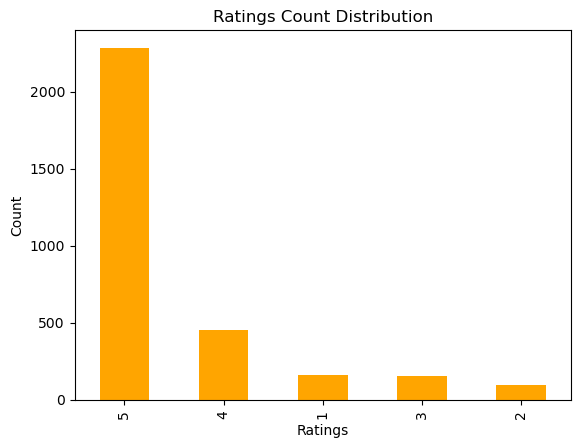

In [20]:
df['rating'].value_counts().plot.bar(color = 'orange')
plt.title('Ratings Count Distribution')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [28]:
print(f"Rating percentage distribution: \n{round(df['rating'].value_counts()/df.shape[0]*100,2)}")

Rating percentage distribution: 
5    72.57
4    14.44
1     5.11
3     4.83
2     3.05
Name: rating, dtype: float64


### Analyzing 'feedback' column

In [29]:
print("Feedback Count\n{}".format(df['feedback'].value_counts()))

Feedback Count
1    2893
0     257
Name: feedback, dtype: int64


In [38]:
# Disable truncation of long strings
pd.set_option('display.max_colwidth', None)
df[df['feedback']==0]['verified_reviews'].head()

46     It's like Siri, in fact, Siri answers more accurately then Alexa.  I don't see a real need for it in my household, though it was a good bargain on prime day deals.
111                                                                                                                  Sound is terrible if u want good music too get a bose
141                                                                                                                                                     Not much features.
162                                                                                Stopped working after 2 weeks ,didn't follow commands!? Really fun when it was working?
176                                                                                                                                                   Sad joke. Worthless.
Name: verified_reviews, dtype: object

In [35]:
df[df['feedback']==1]['verified_reviews'].head()

0                                                                                                                                                                                          Love my Echo!
1                                                                                                                                                                                              Loved it!
2    Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.
3                           I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.
4                                                                                                                                                                                                  M

There are 2 distinct feedback values, where 1 seems to correspond to positive feedbacks, and 0 seems to be for negative feedbacks.

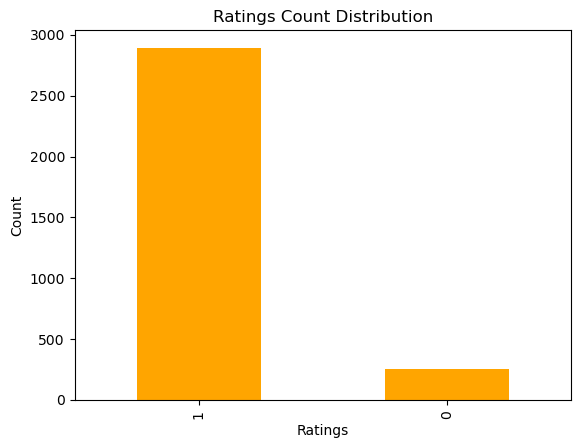

In [36]:
df['feedback'].value_counts().plot.bar(color = 'orange')
plt.title('Ratings Count Distribution')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [41]:
print(f"Feedback percentage distribution: \n{round(df['feedback'].value_counts()/df.shape[0]*100,2)}")

Feedback percentage distribution: 
1    91.84
0     8.16
Name: feedback, dtype: float64


In [43]:
df[df['feedback']==0]['rating'].value_counts()

1    161
2     96
Name: rating, dtype: int64

In [44]:
df[df['feedback']==1]['rating'].value_counts()

5    2286
4     455
3     152
Name: rating, dtype: int64

Feedback value 0 (negative) is associated with rating values 1 and 2.

Feedback value 1 (positive) is associated with rating values 3,4,and 5.

### Analyzing 'variation' column

In [45]:
print("Variation Count\n{}".format(df['variation'].value_counts()))

Variation Count
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64


#### Mean rating value per variation

In [49]:
df.groupby('variation')['rating'].mean().sort_values(ascending=False)

variation
Walnut Finish                   4.888889
Oak Finish                      4.857143
Charcoal Fabric                 4.730233
Heather Gray Fabric             4.694268
Configuration: Fire TV Stick    4.591429
Black  Show                     4.490566
Black  Dot                      4.453488
White  Dot                      4.423913
Black  Plus                     4.370370
White  Plus                     4.358974
Sandstone Fabric                4.355556
White  Spot                     4.311927
Black  Spot                     4.311203
White  Show                     4.282353
Black                           4.233716
White                           4.142857
Name: rating, dtype: float64

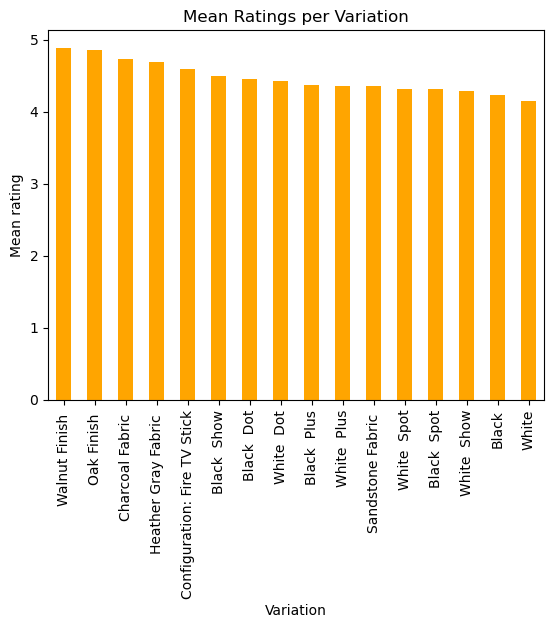

In [50]:
df.groupby('variation')['rating'].mean().sort_values(ascending=False).plot.bar(color = 'orange')

plt.title("Mean Ratings per Variation")
plt.xlabel("Variation")
plt.ylabel("Mean rating")
plt.show()

### Analyzing review_length column

In [52]:
df['review_length'].describe()

count    3150.000000
mean      132.049524
std       182.099952
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: review_length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

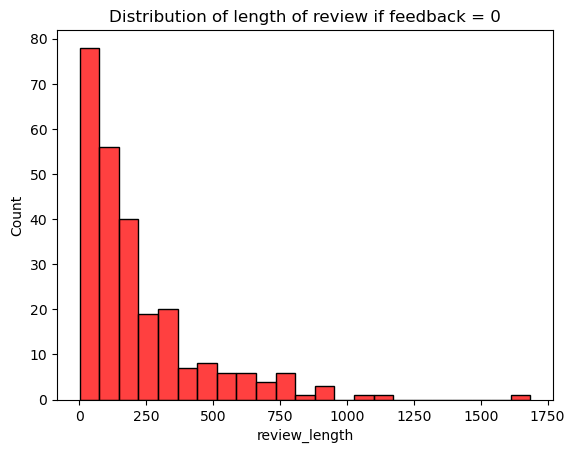

In [53]:
sns.histplot(df[df['feedback']==0]['review_length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

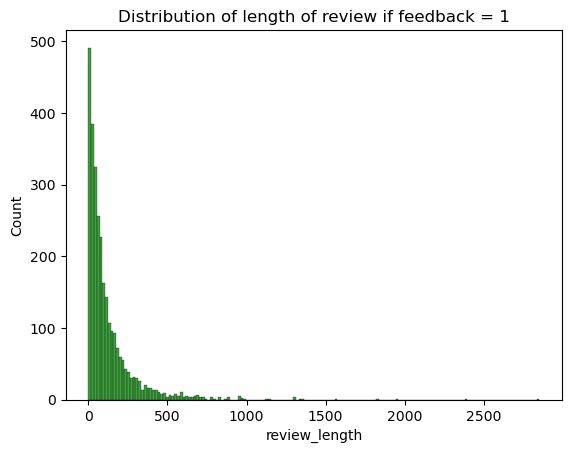

In [55]:
sns.histplot(df[df['feedback']==1]['review_length'], color = 'green').set(title='Distribution of length of review if feedback = 1')

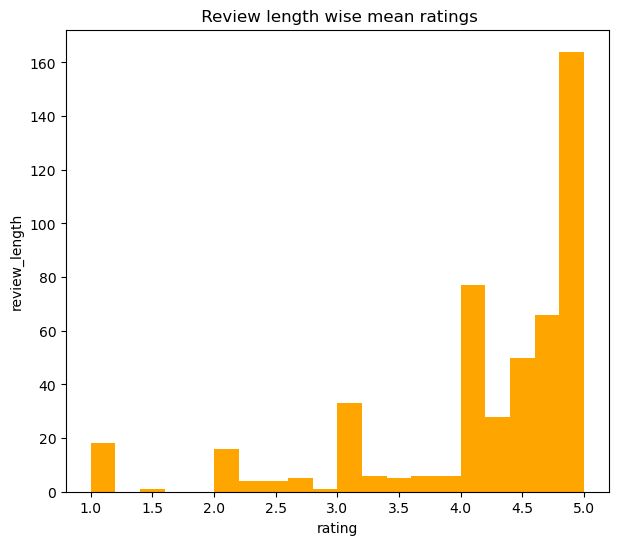

In [60]:
df.groupby('review_length')['rating'].mean().plot.hist(color = 'orange', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('rating')
plt.ylabel('review_length')
plt.show()

Positive reviews are longer than negative reviews

In [62]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.verified_reviews)

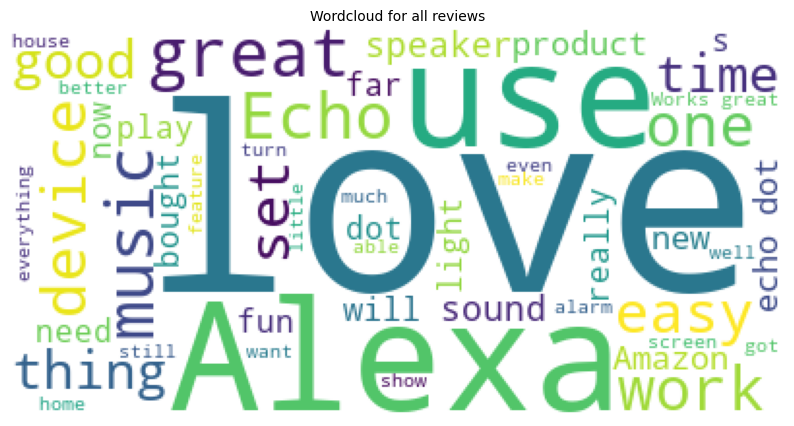

In [63]:
# Combine all reviews
reviews = " ".join([review for review in df['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [70]:
# Combine all reviews for each feedback category
neg_reviews = " ".join([review for review in df[df['feedback']==0]['verified_reviews']])
pos_reviews = " ".join([review for review in df[df['feedback']==1]['verified_reviews']])

#splitting reviews into individual words
neg_reviews = neg_reviews.lower().split()
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


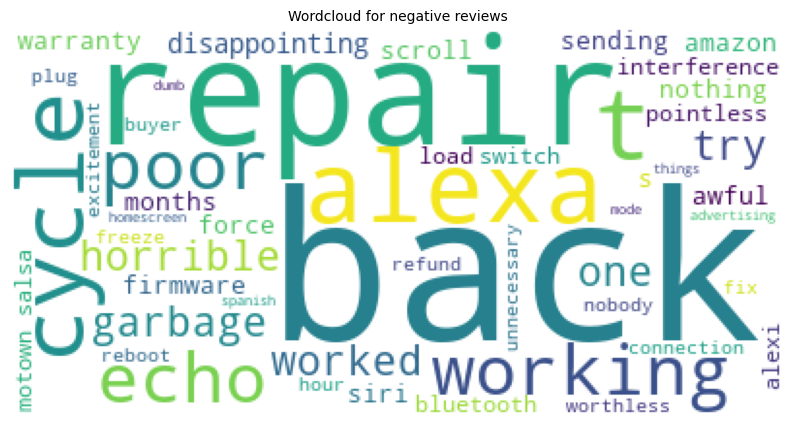

In [71]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

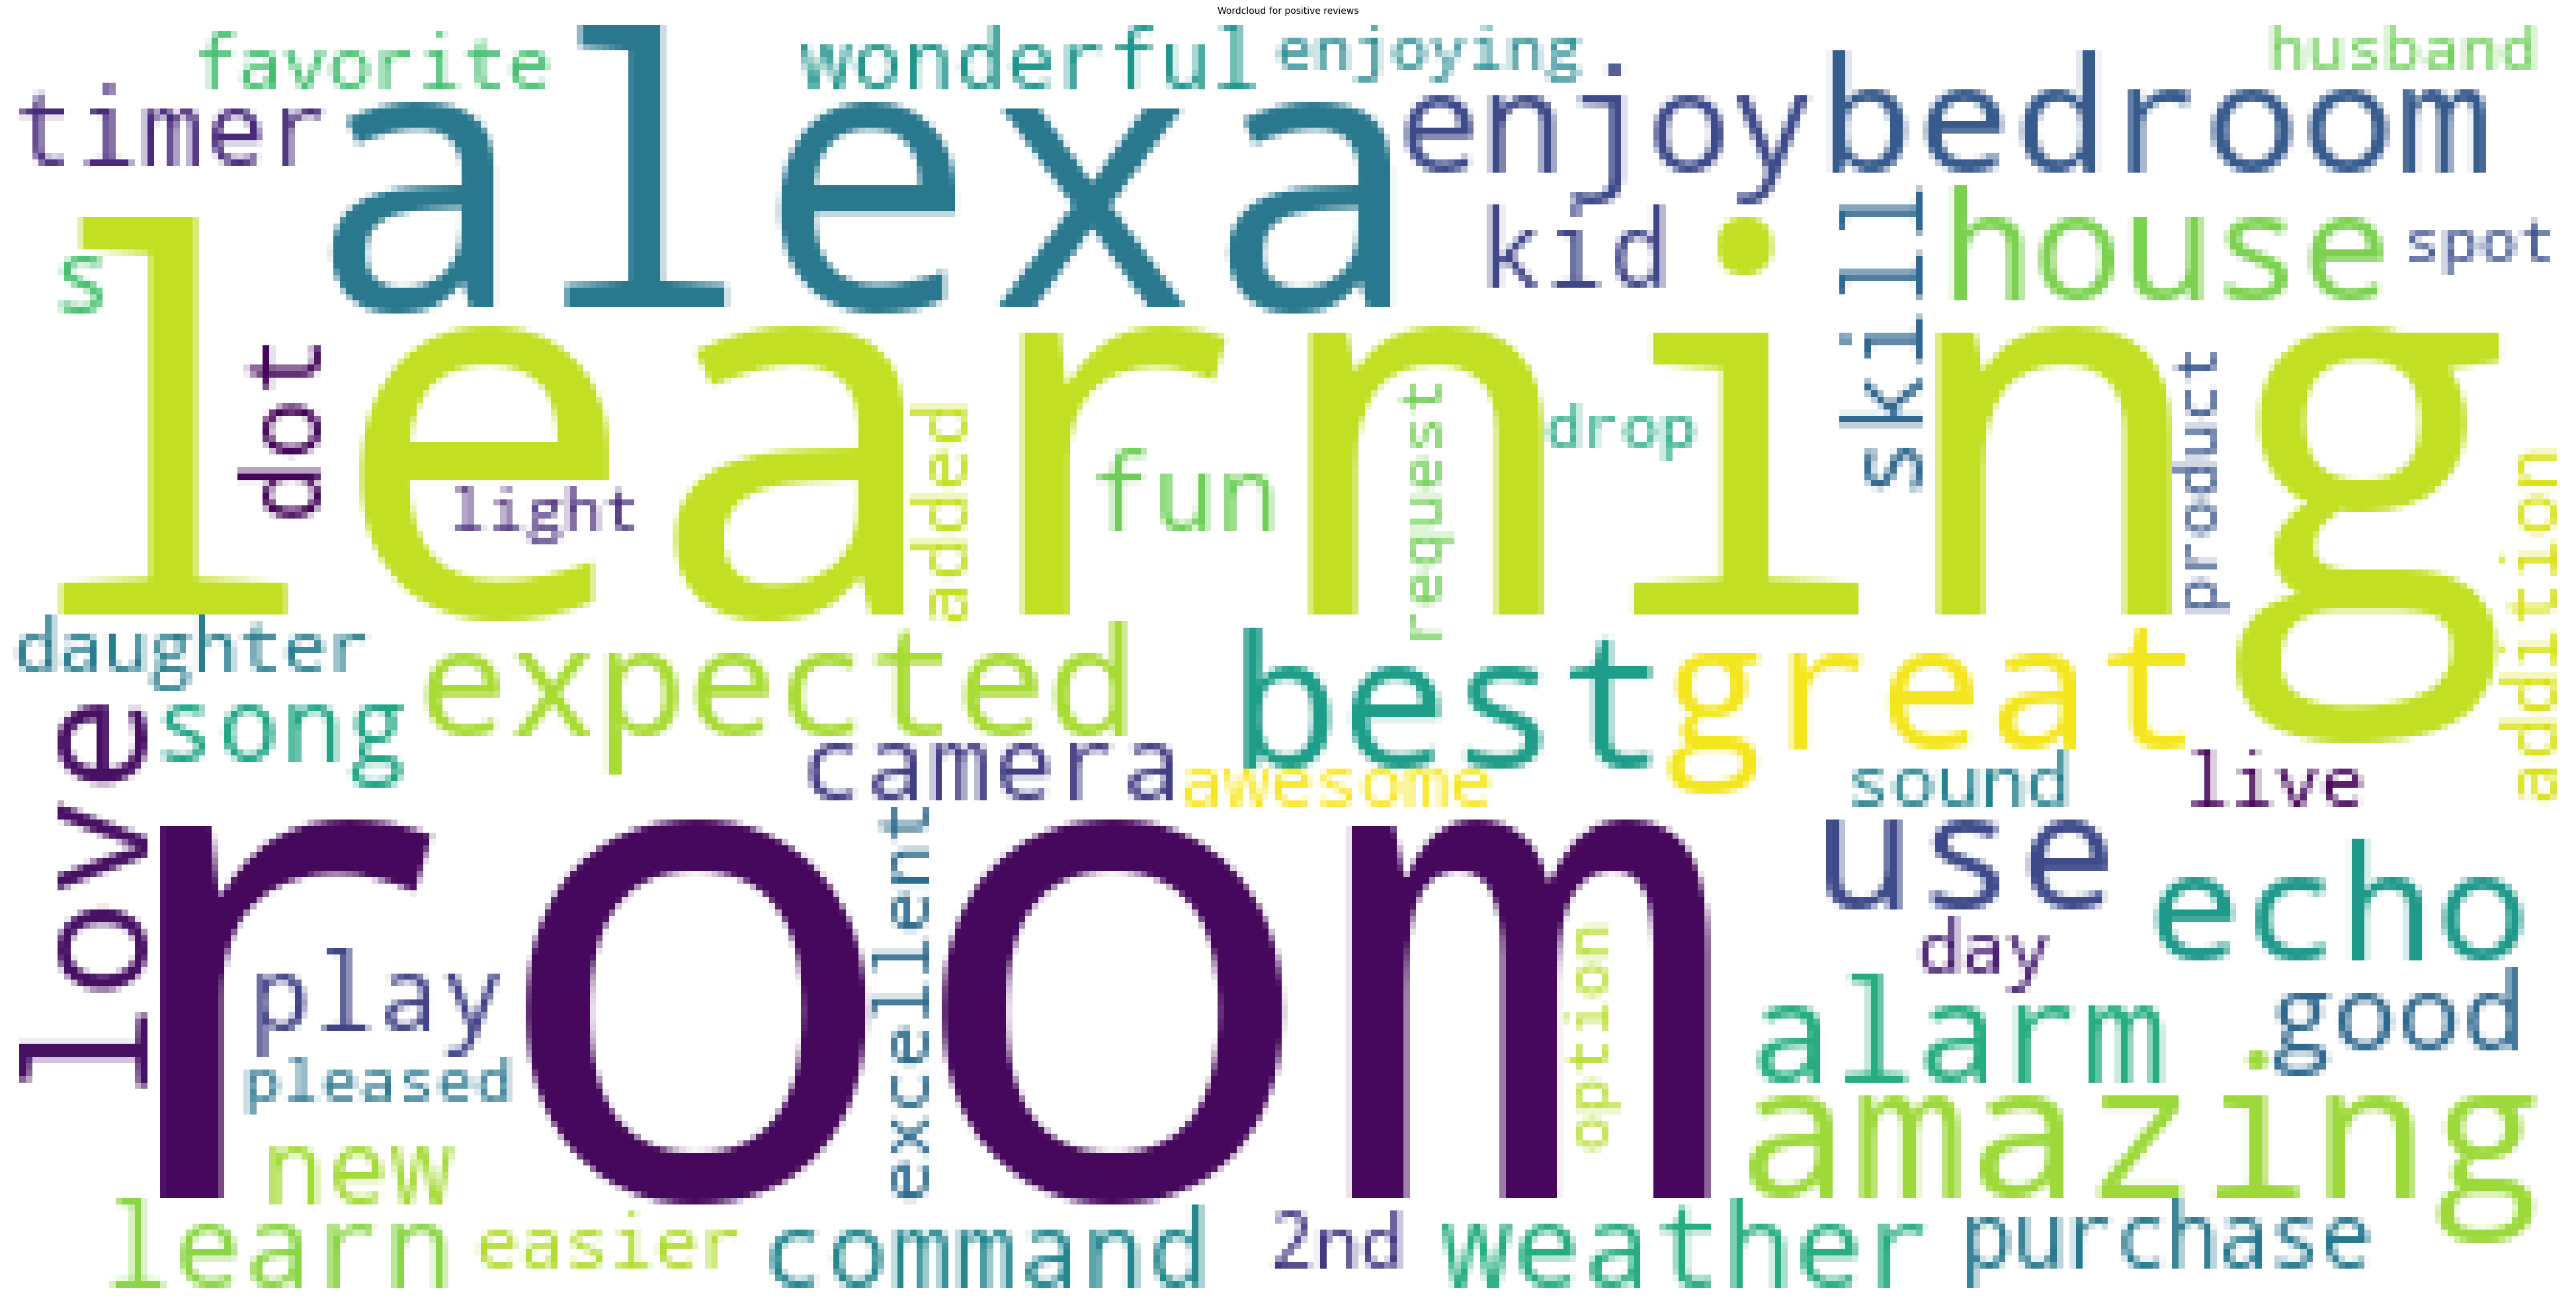

In [74]:
wc = WordCloud(background_color='white', max_words=50)
plt.figure(figsize=(50,50))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following:

1. Replace any non alphabet characters with a space
2. Convert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [76]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [87]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

In [88]:
print(X.shape, y.shape)

(3150, 2500) (3150,)


In [ ]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

#### Splitting the data into testing (30% of overall data) and training data sets.

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2205, 2500)
y train: (2205,)
X test: (945, 2500)
y test: (945,)


In [91]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [92]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [96]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9941043083900227
Testing Accuracy : 0.9407407407407408
